# Explore Physionet Challenge 2012

History
- 12/5/2023 created, jpb

Outline
- Introduction
   - https://physionet.org/content/challenge-2012/1.0.0/
   - Mortality prediction for patients with >= 48 hours of ICU time.
- Data Cleaning
- Data Management
  - Train/Test/Validation split
- Building Blocks
  - Feature construction
  - Feature EDA
  - Model Construction
  - Model Performance
  - Model Analysis
- Exploratory Data Analysis

In [ ]:
import sys, os, math
#from pathlib import Path

import pandas as pd
import numpy  as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from scipy.stats import pearsonr
import sklearn

In [ ]:
#from xgboost import XGBClassifier
#import xgboost
#import shap

In [ ]:
import scipy.stats as stats
#from sklego.linear_model import LowessRegression

In [ ]:
print(f'python : {sys.version}')
print(f'pandas : {pd.__version__}')
print(f'numpy  : {np.__version__}')
print(f'MPL    : {matplotlib.__version__}')
print(f'SNS    : {sns.__version__}')
print(f'sklearn: {sklearn.__version__}')
#print(f'shap   : {shap.__version__}')
#print(f'xgboost: {xgboost.__version__}')

In [ ]:
#sklearn.show_versions()

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#sys.path.insert(0, str(Path.home() / 'SageMaker/jpb/dev/lowess'))

In [ ]:
import lowess

In [ ]:
dfa_full      = pd.read_csv("dfa-full.csv.gz")
outcomes_full = pd.read_csv("outcomes-a-full.csv")

### Train Test Split

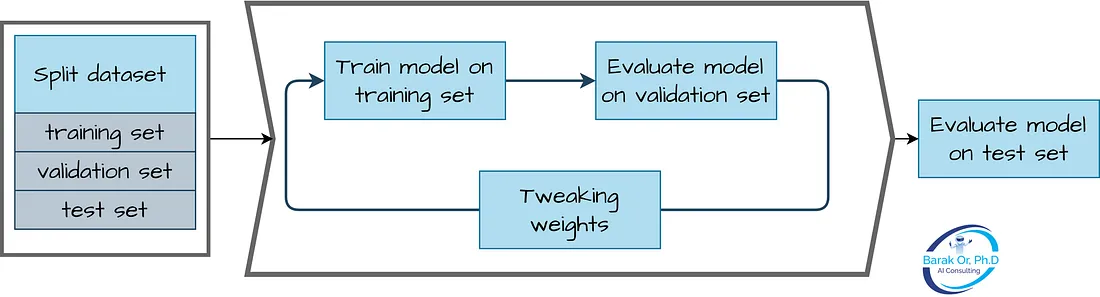

Ref: https://pub.towardsai.net/breaking-the-mold-challenging-the-common-split-for-training-validation-and-test-sets-in-machine-271fd405493d

In [ ]:
all_rids = sorted(dfa_full.record_id.unique())
train_rids, test_rids = train_test_split(all_rids, test_size=0.3, random_state=2023)
print(f"Total record_ids: {len(all_rids)}")
print(f"Train record_ids: {len(train_rids)}")
print(f"Test record_ids : {len(test_rids)}")

In [ ]:
dfa_train = dfa_full[dfa_full.record_id.isin(train_rids)]
dfa_test  = dfa_full[dfa_full.record_id.isin(test_rids)]

outcomes_train = outcomes_full[outcomes_full.record_id.isin(train_rids)].copy()
outcomes_test  = outcomes_full[outcomes_full.record_id.isin(test_rids)].copy()

### Data Format

Data is in entity / attribute / value format
- **Entity**: record_id identifies the admission
- **Attributes**: Parameter and Time identify the type of observation and when it was taken
- **Value**: Values is the observation

In [ ]:
dfa_train.head()

Some attributes are recorded more often than others

In [ ]:
dfa_train.Parameter.value_counts() / dfa_train.record_id.nunique()

**Observations**
- Vitals (HR, ABP, etc) generally recorded multiple time during the 48 hours
- Demographics (Age, Gender, Height) are recorded once
- Some elements (eg Troponins, cholesterol) are not recorded for every record.

**Q** Why is weight recorded multiple times?

### Exploratory Data Analysis - Time Series

We can start exploring the raw data ....

In [ ]:
#
# Plot vitals for 2 admissions
#  - 138144 has outcome adm_death = 0
#  - 132551 has outcome adm_death = 1
#
vars = ['HR', 'SysABP', 'Temp']
fig, ax = plt.subplots(3, 1)
fig.set_figheight(4*len(vars))
fig.set_figwidth(12)

for record_id in [138144, 132551]:
    t = dfa_train[dfa_train.record_id == record_id].sort_values('Time')
    for i, v in enumerate(vars):
        tv = t[t.Parameter == v]
        ax[i].scatter(tv.Time, tv.Value, label=str(record_id))
for i, v in enumerate(vars):
    ax[i].set_ylabel(v)
    ax[i].legend()
ax[-1].set_xlabel("Time (hr)");
#fig.tight_layout()

<div class="alert alert-block alert-warning " style='color: black;'>
    
**Challenges**
- This is time series data
- Most machine learning methods do not work this directly
- Instead they use statistics generated from the time series data

=> For simplicity, let's focus on generating statistical summaries (and exploring them)  
    
</div>

### Generate a Feature Matrix

**Overall goal**: Generate design matrix `X` and output vector `y`
- `X` has one row per admission record
- Each column in `X` is feature computed from time-series data, eg.
   - `HR_mean` is mean heart-rate
   - `Urine_sum` is total of urine samples
   - `TroponinI_present` is 1 if record has a tropnonin, 0 otherwise
- `y` has one entry per each admission record
   - 0 indicates admission ends with patient alive
   - 1 indicated admission ends in death

We can than use supervised learning to find weights (w) for machine learning models for classification
(F) that minimize prediction error, defined by a loss function

For logistic regression,

F(X, w) = 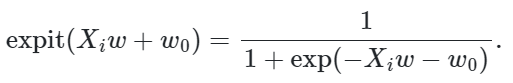

with the loss (or cost function):

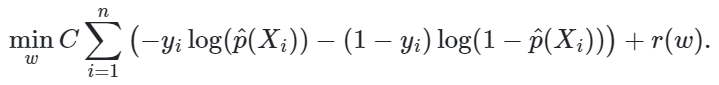

Once the data is formulated as predictors X and outcome y, additional
meachine learning techniques beyound logistic regression can be employed.

### Feature matrix `simple_fm` - mean of all varaiables

In [ ]:
#
# step 1 - use groupby and aggregate to compute mean of each parameter
#
features_1 = (
    dfa_train.query("Parameter != 'RecordID'")
             .groupby(['record_id', 'Parameter'])
             .agg(Value = ('Value', 'mean'))
             .reset_index() )

#
# step 2 - pivot from "narrow" key/value format into "wide" format
#
features_2 = features_1.pivot(index='record_id', columns='Parameter', values='Value').reset_index()

#
# step 3 - join with the outcome 'adm_mortality'
#
simple_fm = pd.merge(
    features_2,
    outcomes_train[['record_id', 'adm_death']],
    validate = '1:1')

In [ ]:
simple_fm.head()

### Configurable feature matrix

Build various statistics features over various time ranges

In [ ]:
def build_stat_features(df, features):
    """
    Build statistical summary features (aka X) for Physionet-2012 Challenge Data
    
    Args
     - df    - Physionet 2012 dataset
     - fspec - feature specification
               List of
                 dict(var="<Parameter>",
                      stats=["stat1", ...],
                      dur=[<start>, <stop>], # optional
                      {name="<name>"})       # optional
    """
    #
    # find features with same name
    #
    name_counts = {}
    for ent in features:
        if 'name' not in ent:
            ent['name'] = ent['var']
        n = ent['name']
        if n not in name_counts:
            name_counts[n] = 0
        name_counts[n] += 1
    
    for k in list(name_counts.keys()):
        if name_counts[k] == 1:
            del name_counts[k]
        else:
            name_counts[k] = 0
    
    #
    # rename features with same name
    #
    for ent in features:
        n = ent['name']
        if n in name_counts:
            ent['name'] = f"{n}_{name_counts[n]}"
            name_counts[n] += 1
            print(f"rename: {n} -> {ent['name']}")
    
    res = []
    for ent in features:
        var   = ent['var']
        stats = ent['stats']
        name  = ent.get('name', var)
        dur   = ent.get('dur', [0, 48.1])
        
        agg_args = {}
        for stat in stats:
            if stat == 'present':
                func = 'count'
            else:
                func = stat
            agg_args[f'_{stat}'] = ('Value', func)
        
        t = (df.query(f"Parameter == '{var}' & "
                      f"Time >= {dur[0]} & Time < {dur[1]}")
               .groupby(['record_id'])
               .agg(**agg_args) )

        t.columns = [f"{name}{_}" for _ in t.columns]       
        res.append(t)
        
    res = pd.concat(res, axis=1).reset_index()
    
    #
    # fill in empty rows for missing record_ids
    #
    missing_rids = list(set(df.record_id.unique()) - set(res.record_id.unique()))
    if len(missing_rids) > 0:
        res_fill = pd.DataFrame(dict(record_id = missing_rids))
        res = pd.concat([res, res_fill], axis=0, ignore_index=True)
    
    for var in res.columns:
        if var.endswith('_count'):
            res[var] = res[var].fillna(0)
        if var.endswith('_present'):
            res[var] = (res[var].fillna(0) > 0).astype(int)
    
    return res

def add_outcome(fm_df_or_list, outcomes):
    """
    Combine sets of features (X_i, X_1, etc) and join outcome y
    """
    if type(fm_df_or_list) is list:
        fm = fm_df_or_list[0]
        for df in fm_df_or_list[1:]:
            fm = pd.merge(fm, df, on = 'record_id', how='outer')
    else:
        fm = fm_df_or_list
    
    fm = pd.merge(
        fm,
        outcomes[['record_id', 'adm_death']],
        how = 'left')

    return fm

### Feature matrix `fm_1` - Age + Average Values of vitals + total urine

In [ ]:
feature_spec_1 = [
    dict(var='Age',       stats = ['first']),
    dict(var='HR',        stats = ['mean']),
    dict(var='RespRate',  stats = ['mean']),
    dict(var='SysABP',    stats = ['mean']),
    dict(var='Temp',      stats = ['mean']),
    dict(var='TroponinT', stats = ['present']),
    dict(var='Urine',     stats = ['sum']),
]
    
fm_1 = add_outcome(
    build_stat_features(dfa_train, feature_spec_1),
    outcomes_train)

In [ ]:
# feature_spec = [
#     dict(var='Age', stats = ['first']),
#     dict(var='HR', stats = ['median', 'min', 'max', 'std']),
#     dict(var='SysABP', dur=[0,24], stats = ['mean', 'min', 'max']),
#     dict(var='SysABP', dur=[24,48], stats = ['mean', 'min', 'max']),
#     dict(var='TroponinT', stats = ['max', 'count', 'present']),
#     dict(var='Urine', stats = ['sum', 'count']),
# ]
# fm1 = build_stat_features(dfa_train, feature_spec)
# dm1 = add_outcome(fm1, outcomes_train)
# #dm1 = combine_features_outcome([fm1], outcome)

### Exploratory Data Analysis - Univariate

In [ ]:
def jitter(s, width):
    rng = np.random.default_rng()
    w2 = width/2
    j = rng.uniform(-w2,+w2, len(s))
    return s + j

def get_all_vars(df, outcome):
    return [_ for _ in df.columns if _ not in ['record_id', outcome]]

def plot_dist(df, vars, outcome, cols=2, size=None, stats=True, plot_lowess=True):
    if vars == 'all': vars = get_all_vars(df, outcome)

    group_size = 1
    if plot_lowess:
        lowess_offset = group_size
        group_size += 1
    if stats:
        stats_offset = group_size
        group_size += 1
        
    n_plots = group_size * len(vars)
    rows = int(np.ceil(n_plots/cols))
    
    if size is None:
        if cols == 2: size = 5
        else: size = 4
    
    col_colors = sns.color_palette("pastel").as_hex()
    fig, ax = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
    ax = ax.flatten()
    for i, var in enumerate(vars):
        # plot histogram/distribution
        i0 = group_size * i + 0

        sns.histplot(data=df, x=var, hue=df[outcome], kde=True, stat='density',
             common_norm=False, ax=ax[i0])
        ax[i0].set_title(f"{var} ({df[var].notnull().sum()}/{len(df)})")

        if plot_lowess:
            i1 = group_size * i + lowess_offset
            
            try:
                m = df[var].notnull()
                if 1:
                    sdf = df.loc[m, [var, outcome]].sort_values(var)
                    pred = lowess.lowess(sdf[var], sdf[outcome], bandwidth=0.2, polynomialDegree=1)
                    ax[i1].plot(sdf[var], pred)
                else:
                    sigma = (df[var].max() - df[var].min()) / 5
                    lr = LowessRegression(sigma=sigma, span=1.0).fit(df.loc[m, [var]], df.loc[m, outcome])

                    xs = np.linspace(df[var].min(), df[var].max(), 100)
                    pred = lr.predict(xs.reshape(-1,1))
                    ax[i1].plot(xs, pred)
            except:
                print(f"Exception on Lowess for {var}")
                
            ax[i1].scatter(df[var], jitter(df['adm_death'], 0.1), alpha=0.2, marker='.')
            ax[i1].set_xlabel(var)
            ax[i1].set_ylabel(f"P( {outcome} | {var})")
        
        # plot stats
        if stats:
            i1 = group_size * i + stats_offset

            t = df.groupby(outcome)[var].describe().transpose()
            cell_text = []
            for idx in t.index:
                if idx == 'count':
                    fmt = lambda _: str(int(_))
                else:
                    fmt = lambda _: f"{_:0.1f}"
                cell_text.append([fmt(t.loc[idx, 0]), fmt(t.loc[idx, 1])])
            ax[i1].table(cellText = cell_text, bbox=[0,0,1,1], 
                         colColours=col_colors[0:2],
                         rowColours=["lightgrey"] * len(t),
                         rowLabels=t.index,
                         colLabels=[f"{outcome} {_}" for _ in t.columns])
            ax[i1].axis('off')
    plt.tight_layout()

In [ ]:
plot_dist(fm_1, 'all', 'adm_death', cols=3)

### Exploratory Data Analysis - Correlation

In [ ]:
def plot_corr(df, vars, outcome):
    if vars == 'all': vars = get_all_vars(df, outcome)
    
    def _annotate_corr(x, y, ax=None, **kws):
        m = x.notnull() & y.notnull()
        r, _ = pearsonr(x[m], y[m])
        ax = ax or plt.gca()
        ax.annotate(f'ρ = {r:.2f}', xy=(0.1, 0.9), xycoords=ax.transAxes,
                   bbox=dict(boxstyle="round", fc="w"))
    
    pp = sns.pairplot(df[vars + [outcome]], hue=outcome, kind='reg', markers=['.', '*'])
    pp.map_lower(_annotate_corr)

In [ ]:
plot_corr(fm_1, 'all', 'adm_death')

In [ ]:
feature_spec_bp = [
    dict(var='SysABP', stats = ['mean']),
    dict(var='DiasABP', stats = ['mean']),
    dict(var='MAP', stats = ['mean']),
]
    
fm_bp = add_outcome(
    build_stat_features(dfa_train, feature_spec_bp),
    outcomes_train)

In [ ]:
plot_corr(fm_bp, 'all', 'adm_death')

Highly correlated Vairables

In [ ]:
feature_spec_path_age = [
    dict(var='Age',       stats = ['min', 'max']),
]
    
fm_path_age = add_outcome(
    build_stat_features(dfa_train, feature_spec_path_age),
    outcomes_train)

In [ ]:
plot_corr(fm_path_age, 'all', 'adm_death')

### Data Preparation - Missing Value Imputation, Scaling

In [ ]:
X_train = fm_1[fm_1.columns[1:-1]]
y_train = fm_1['adm_death'] 

In [ ]:
X_train.head()

**Notes**:
- `X_train` contains missing values => impute
- Many machine learning algorithms work better when variables are normalized (zero mean, unit standard deviation)

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')

scale = StandardScaler()

X_train_imp   = imp.fit_transform(X_train)
X_train_scale = scale.fit_transform(X_train_imp)

del X_train_imp

### Build Model

In [ ]:
model = LogisticRegression()
model.fit(X_train_scale, y_train);

### Evaluate Model on Training Data

In [ ]:
auroc_train = roc_auc_score(y_train, model.predict_proba(X_train_scale)[:, 1])
print(auroc_train)

In [ ]:
if 0:
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_train_scale, y_train,
    cmap = plt.cm.Blues)
else:
    y_pred = model.predict(X_train_scale)
    cm = confusion_matrix(y_train, y_pred)
    metrics.ConfusionMatrixDisplay(cm).plot()

In [ ]:
def simple_metrics(model, XX_imp, yy_true):
    yy_pred = model.predict(XX_imp)
    cm = confusion_matrix(yy_true, yy_pred)

    print(cm)

    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]

    sens = TP / (TP + FN) # aka "recall"
    spec = TN / (TN + FP)
    PPV  = TP / (TP + FP) # aka "precision"

    print(f" - Sensitivity = {sens}")
    print(f" - Specificity = {spec}")
    print(f" - PPV         = {PPV}")
    
simple_metrics(model, X_train_scale, y_train)

### Evaluate Model on Test Data

In [ ]:
fm_1_test = add_outcome(
    build_stat_features(dfa_test, feature_spec_1),
    outcomes_test)

X_test = fm_1_test[fm_1_test.columns[1:-1]]
y_test = fm_1_test['adm_death']

X_test_imp   = imp.transform(X_test)
X_test_scale = scale.transform(X_test_imp)

del X_test, X_test_imp

In [ ]:
auroc_test = roc_auc_score(y_test, model.predict_proba(X_test_scale)[:, 1])
print(f"Test AUROC: {auroc_test}")

In [ ]:
if 0:
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test_scale, y_test,
    cmap = plt.cm.Blues)
else:
    y_pred = model.predict(X_test_scale)
    cm = confusion_matrix(y_test, y_pred)
    metrics.ConfusionMatrixDisplay(cm).plot()

In [ ]:
simple_metrics(model, X_test_scale, y_test)

### Plot AUROC

In [ ]:
def roc_curve_display(model, XX, yy):
    pred = model.predict_proba(XX)
    fpr, tpr, thresholds = metrics.roc_curve(yy, pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    return display

if 0:
    RocCurveDisplay.from_estimator(model, X_train_scale, y_train)
    RocCurveDisplay.from_estimator(model, X_test_scale, y_test, ax=plt.gca());
else:
    display = roc_curve_display(model, X_train_scale, y_train)
    display.plot()
    display = roc_curve_display(model, X_test_scale, y_test)
    display.plot(ax=plt.gca())

### Use SAPS-1 Variables + min/max

In [ ]:
feature_spec_1_max = [
    dict(var='Age',       stats = ['first']),
    dict(var='HR',        stats = ['min', 'max']),
    dict(var='RespRate',  stats = ['min', 'max']),
    dict(var='SysABP',    stats = ['min', 'max']),
    dict(var='Temp',      stats = ['min', 'max']),
    dict(var='BUN',       stats = ['min', 'max']),
    dict(var='HCT',       stats = ['min', 'max']),
    dict(var='WBC',       stats = ['min', 'max']),
    dict(var='Glucose',   stats = ['min', 'max']),
    dict(var='K',         stats = ['min', 'max']),
    dict(var='Na',        stats = ['min', 'max']),
    dict(var='HCO3',      stats = ['min', 'max']),
    dict(var='GCS',       stats = ['min', 'max']),
    dict(var='TroponinT', stats = ['present']),
    dict(var='Urine',     stats = ['sum']),
]

#
# Setup train data
#

fm_1_max = add_outcome(
    build_stat_features(dfa_train, feature_spec_1_max),
    outcomes_train)

X_train = fm_1_max[fm_1_max.columns[1:-1]]
y_train = fm_1_max['adm_death'] 

imp = SimpleImputer(missing_values=np.nan, strategy='median')

scale = StandardScaler()

X_train_imp   = imp.fit_transform(X_train)
X_train_scale = scale.fit_transform(X_train_imp); del X_train_imp



#
# Setup test data
#
fm_1_max_test = add_outcome(
    build_stat_features(dfa_test, feature_spec_1_max),
    outcomes_test)

X_test = fm_1_max_test[fm_1_max_test.columns[1:-1]]
y_test = fm_1_max_test['adm_death']

X_test_imp   = imp.transform(X_test)
X_test_scale = scale.transform(X_test_imp)

del X_test, X_test_imp

#
# Build Model
#

model = LogisticRegression()
model.fit(X_train_scale, y_train);

#
# Measure Train Performance
#
simple_metrics(model, X_train_scale, y_train)
auroc_train = roc_auc_score(y_train, model.predict_proba(X_train_scale)[:, 1])
print(f"Test AUROC: {auroc_train}")

#
# Measure Test Performance
#
simple_metrics(model, X_test_scale, y_test)
auroc_test = roc_auc_score(y_test, model.predict_proba(X_test_scale)[:, 1])
print(f"Test AUROC: {auroc_test}")

if 0:
    RocCurveDisplay.from_estimator(model, X_train_scale, y_train)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(model, X_test_scale, y_test, ax=ax)
else:
    display = roc_curve_display(model, X_train_scale, y_train)
    display.plot()
    display = roc_curve_display(model, X_test_scale, y_test)
    display.plot(ax=plt.gca())

### Feature Importance

In [ ]:
r_multi = permutation_importance(
          model, X_test_scale, y_test, n_repeats=30, random_state=0, scoring=['roc_auc'])

In [ ]:
feature_names = X_train.columns
r = r_multi['roc_auc']
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i]:15}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

In [ ]:
if 0: # not available on fresh crunchr
    explainer = shap.LinearExplainer(model, X_test_scale)
    shap_values = explainer.shap_values(X_test_scale)
    shap.summary_plot(shap_values, X_test_scale, feature_names = X_train.columns)

In [ ]:
n_plots = len(X_train.columns)
cols=4
rows = int(np.ceil(n_plots/cols))
size=5

fig, ax = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
ax = ax.flatten()

PartialDependenceDisplay.from_estimator(model, X_train_scale, features=list(range(len(X_train.columns))),
                                        ax=ax[:n_plots])

for i, v in enumerate(X_train.columns):
    ax[i].set_xlabel(v)
fig.tight_layout()

### Try Other Models

In [ ]:
# Uses X/y_train/test from previouys cell

#
# Build Model
#

#model = XGBClassifier() # not available on crunchr
#model = HistGradientBoostingClassifier() # Not available on crunchr
model = RandomForestClassifier()
#model = SVC(probability=True)
model.fit(X_train_scale, y_train);

#
# Measure Train Performance
#
simple_metrics(model, X_train_scale, y_train)
auroc_train = roc_auc_score(y_train, model.predict_proba(X_train_scale)[:, 1])
print(f"Test AUROC: {auroc_train}")

#
# Measure Test Performance
#
simple_metrics(model, X_test_scale, y_test)
auroc_test = roc_auc_score(y_test, model.predict_proba(X_test_scale)[:, 1])
print(f"Test AUROC: {auroc_test}")

if 0:
    RocCurveDisplay.from_estimator(model, X_train_scale, y_train)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(model, X_test_scale, y_test, ax=ax)
else:
    display = roc_curve_display(model, X_train_scale, y_train)
    display.plot()
    display = roc_curve_display(model, X_test_scale, y_test)
    display.plot(ax=plt.gca())

### Evaluate Several Models

In [ ]:
def eval_models(models, X_train_scale, y_train, X_test_scale, y_test):
    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(6)
    fig.set_figwidth(2*6)
    
    for n, model in models.items():
        model.fit(X_train_scale, y_train);

        #
        # Measure Train Performance
        #
        # simple_metrics(model, X_train_scale, y_train)
        # auroc_train = roc_auc_score(y_train, model.predict_proba(X_train_scale)[:, 1])
        # print(f"Test AUROC: {auroc_train}")

        #
        # Measure Test Performance
        #
        # simple_metrics(model, X_test_scale, y_test)
        # auroc_test = roc_auc_score(y_test, model.predict_proba(X_test_scale)[:, 1])
        # print(f"Test AUROC: {auroc_test}")

        if 0:
            RocCurveDisplay.from_estimator(model, X_train_scale, y_train, ax=ax[0], name=n)
            RocCurveDisplay.from_estimator(model, X_test_scale, y_test, ax=ax[1], name=n)
        else:
            display = roc_curve_display(model, X_train_scale, y_train)
            display.plot(ax=ac[0], name=n)
            display = roc_curve_display(model, X_test_scale, y_test)
            display.plot(ax=ax[1], name=n

In [ ]:
models = {
    'LogR':  LogisticRegression(),
    'SVC-0.5': SVC(probability=True, C=0.5),
    'SVC-1.0': SVC(probability=True, C=1.0),
    'SVC-5.0': SVC(probability=True, C=5.0),
    #'XGBoost': XGBClassifier(),
    #'HGBC':    HistGradientBoostingClassifier(),
    'RF':      RandomForestClassifier()}

eval_models(models,
            X_train_scale, y_train, X_test_scale, y_test)